# GradCAMによる可視化
## 以下のリンクに記載されているGrad_CAMの実装を試す。
## https://www.noconote.work/entry/2019/01/12/231723

In [1]:
# モジュールのインポート
%matplotlib inline
import urllib
import pickle
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms
#from torchvision import models
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from pathlib import Path
from IPython.core.debugger import Pdb

# 自作関数
import models
from utils import load_model
from dataset import TrainDataset, TTADataset, get_ids, N_CLASSES, DATA_ROOT

In [2]:
#labels = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

In [44]:
class GradCam:
    def __init__(self, model):
        self.model = model.eval()
        self.feature = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x):
        image_size = (x.size(-1), x.size(-2))
        feature_maps = []
        
        for i in range(x.size(0)):
            img = x[i].data.cpu().numpy()
            img = img - np.min(img)
            if np.max(img) != 0:
                img = img / np.max(img)

            feature = x[i].unsqueeze(0)
            
            #Pdb().set_trace()
            
            # 特徴の抽出
            # avgpoolの一つ前がfeature
            for ind,(name, module) in enumerate(model.net.named_children()):
               # print(name)
                if name == "avgpool":
                    avgpool_ind = ind
                    
          #  feature_ind = avgpool_ind - 1
            
            feature_module = nn.Sequential(*list(model.children())[:avgpool_ind]).eval() 
            classify_module =  nn.Sequential(*list(model.children())[avgpool_ind:]).eval() 
            
            # 中間層の出力を取り出し
            feature = feature_module(feature)
            feature.register_hook(self.save_gradient)
            self.feature = feature
            
        #    Pdb().set_trace()
            
            feature = feature.view(feature.size(0), -1)
            feature = classify_module(feature)
                   
            """for i,(name, module) in enumerate(model.named_children()):
                if i = avgpool_ind:
                     feature = feature.view(feature.size(0), -1)
                feature = module(feature)
                feature.register_hook(self.save_gradient)"""
           
            """for name, module in self.model.named_children():
                if name == 'classifier':
                    feature = feature.view(feature.size(0), -1)
                feature = module(feature)
                if name == 'features':
                    feature.register_hook(self.save_gradient)
                    self.feature = feature
            """        
            
            Pdb().set_trace()
            
            classes = F.sigmoid(feature)
            one_hot, _ = classes.max(dim=-1)
            self.model.zero_grad()
            one_hot.backward()

            weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
            
            mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
            mask = cv2.resize(mask.data.cpu().numpy(), image_size)
            mask = mask - np.min(mask)
            
            if np.max(mask) != 0:
                mask = mask / np.max(mask)
                
            feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
            cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
            cam = cam - np.min(cam)
            
            if np.max(cam) != 0:
                cam = cam / np.max(cam)
                
            feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))
            
        feature_maps = torch.stack(feature_maps)
        
        return feature_maps

image size:  (288, 288)


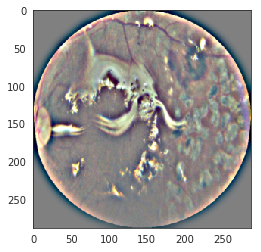

In [5]:
# 入力画像の読み込み
# TODO : IMG_SIZEをtransformから読み込めるようにする

IMG_SIZE = 288
#IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_image = Image.open("../images/_debug.png")
test_image_tensor = (transform((test_image))).unsqueeze(dim=0)

image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)

In [7]:
from torchvision import models
vg19 = models.vgg19(pretrained=True)

In [6]:
# モデルの読み込み (網膜コンペ)
apotos = True
if apotos:
    model = "resnet50"
    pretrained = True
    run_root = Path("Rockman_aug_nonCircleCrop/Rockman_aug_nonCircleCrop_0")

    model = getattr(models, "resnet50")(
        num_classes=N_CLASSES, pretrained=pretrained)

   # model = model.cuda()
    load_model(model, run_root / 'best-model.pt') 

Loaded model from epoch 22, step 903


In [15]:
for i,(name, module) in enumerate(vg19.named_children()):
    print(name)
   # if name == "avgpool":
   #     avgpool_ind = i

NameError: name 'vg19' is not defined

In [72]:
class GradCam:
    def __init__(self, model):
        self.model = model.eval()
        self.feature = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x):
        image_size = (x.size(-1), x.size(-2))
        feature_maps = []
        
        for i in range(x.size(0)):
            img = x[i].data.cpu().numpy()
            img = img - np.min(img)
            if np.max(img) != 0:
                img = img / np.max(img)

            feature = x[i].unsqueeze(0)
            
            for ind,(name, module) in enumerate(model.net.named_children()):
               # print(name)
                if name == "avgpool":
                    avgpool_ind = ind
                    
          #  feature_ind = avgpool_ind - 1
            
            feature_module = nn.Sequential(*list(model.net.children())[:avgpool_ind]).eval() 
            
            for name, module in self.model.net.named_children():
                print(name)
                if name == "fc": # 最終の分類層
                    feature = feature.view(feature.size(0), -1)
                    feature = module(feature)
                    
                if name == "avgpool":
                    # 特徴抽出層から特徴を抽出
                 #   Pdb().set_trace()
                    feature = feature_module(feature)
                    feature.register_hook(self.save_gradient)
                    self.feature = feature
                   # post_avg_pool = 1
                    feature = module(feature)
                        
           # Pdb().set_trace()
            classes = F.sigmoid(feature)
            one_hot, _ = classes.max(dim=-1)
            self.model.zero_grad()
            one_hot.backward()

            weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
            
            mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
            mask = cv2.resize(mask.data.cpu().numpy(), image_size)
            mask = mask - np.min(mask)
            
            if np.max(mask) != 0:
                mask = mask / np.max(mask)
                
            feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
            cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
            cam = cam - np.min(cam)
            
            if np.max(cam) != 0:
                cam = cam / np.max(cam)
                
            feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))
            
        feature_maps = torch.stack(feature_maps)
        
        return feature_maps

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


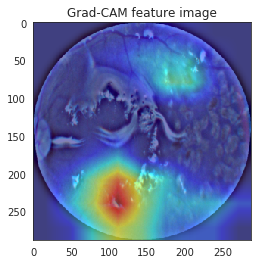

In [73]:
#grad_cam = GradCam(model)
grad_cam = GradCam(model)

feature_image = grad_cam(test_image_tensor).squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)

pred_idx = model(test_image_tensor).max(1)[1]
#print("pred: ", labels[int(pred_idx)])
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))